In [14]:
# ===============================
# AUTHOR: Andras Balint, andras.balint@unibe.ch / stefan.weder@insel.ch
# CREATE DATE: 23.08.2023
# PURPOSE: Validation of 3D optode registration method
# SPECIAL NOTES: Project: "How patterns of Brain Activation Predict Speech Understanding"
# ===============================
# Change History:
#   - 18.10.2023: - 1st commit to github
#   - 30.10.2023: - 2nd commit to github
# ===============================

# General libraries
import numpy as np
import os
import importlib
import pandas as pd
import itertools
from scipy import stats

# NIRS specific libraries
import mne
import fnirs_3D_e

base_folder = os.getcwd()

ModuleNotFoundError: No module named 'fnirs_3D_e'

In [13]:
import os
import sys
os.path.dirname(sys.executable)

'c:\\Users\\neuro\\AppData\\Local\\Programs\\Python\\Python312'

# Analysis

In [ ]:
importlib.reload(fnirs_3D_e)

# if inter-optode distance is larger than this, assert fails
tolerance_for_mislabel_detection = 7 # mm 
df_pts = pd.DataFrame()

# for interoptode calculation
MPs_1 = []
MPs_2 = []
MPs_3 = []
MPs_MRI = []

# read-in 3D scan coordinates
for sub_idx in [0,1,2,3,4]:
#for sub_idx in [0]:

    mod_opt_pos_1, mod_labels_1 = fnirs_3D_e.ImportPPLocations(base_folder + r"\data\3DSCAN\S" + str(sub_idx+1) + r"\1\1_picked_points.pp")
    mod_opt_pos_2, mod_labels_2 = fnirs_3D_e.ImportPPLocations(base_folder + r"\data\3DSCAN\S" + str(sub_idx+1) + r"\2\2_picked_points.pp")
    mod_opt_pos_3, mod_labels_3 = fnirs_3D_e.ImportPPLocations(base_folder + r"\data\3DSCAN\S" + str(sub_idx+1) + r"\3\3_picked_points.pp")

    # read-in MRI coordinates
    pd_pos_mri = pd.read_json(base_folder + "\data\MRI\S" + str(sub_idx+1) + "\F.mrk.json")
    pd_pos_mri = pd_pos_mri['markups'][0]['controlPoints']

    mod_opt_pos_mri = []
    mod_labels_mri = []
    for cpos in pd_pos_mri:
        mod_opt_pos_mri.append(cpos['position'])
        mod_labels_mri.append(cpos['label'].replace("T", "S").replace("R", "D"))
    mod_opt_pos_mri = np.array(mod_opt_pos_mri)
    mod_labels_mri = np.array(mod_labels_mri)
    mod_opt_pos_mri = mod_opt_pos_mri[mod_labels_mri != 'neck'] # drop neck marker for now
    mod_labels_mri = mod_labels_mri[mod_labels_mri != 'neck']

    # keep optodes where 30mm inter-optode distance is fixed with a spacer
    chs_30mm = ['S1_D1', 'S1_D2', 'S3_D4', 'S3_D6', 'S4_D4', 'S4_D6', 'S5_D7',
                'S6_D7', 'S6_D10', 'S7_D7', 'S7_D10', 'S7_D9', 'S8_D10', 'S8_D9', 'S9_D9',
                'S10_D12', 'S10_D13', 'S11_D12', 'S11_D13', 'S13_D15', 'S13_D16', 'S14_D2',  
                'S15_D16', 'S16_D2']
    
    optodes_30mm = []
    for c_ch_name in chs_30mm:
        optodes_30mm.append(c_ch_name.split('_')[0])
        optodes_30mm.append(c_ch_name.split('_')[1])
    all_points = ['lpa', 'rpa', 'nas'] + list(np.unique(optodes_30mm))

    mod_opt_pos_1 = mod_opt_pos_1[np.isin(mod_labels_1, all_points)]
    mod_opt_pos_2 = mod_opt_pos_2[np.isin(mod_labels_2, all_points)]
    mod_opt_pos_3 = mod_opt_pos_3[np.isin(mod_labels_3, all_points)]
    mod_opt_pos_mri = mod_opt_pos_mri[np.isin(mod_labels_mri, all_points)]

    mod_labels_1 = mod_labels_1[np.isin(mod_labels_1, all_points)]
    mod_labels_2 = mod_labels_2[np.isin(mod_labels_2, all_points)]
    mod_labels_3 = mod_labels_3[np.isin(mod_labels_3, all_points)]
    mod_labels_mri = mod_labels_mri[np.isin(mod_labels_mri, all_points)]

    # rigid registration
    mod_opt_pos_1_cc = fnirs_3D_e.CoordinatesPipeline(mod_opt_pos_1, mod_labels_1)
    mod_opt_pos_2_cc = fnirs_3D_e.CoordinatesPipeline(mod_opt_pos_2, mod_labels_2)
    mod_opt_pos_3_cc = fnirs_3D_e.CoordinatesPipeline(mod_opt_pos_3, mod_labels_3)
    mod_opt_pos_mri_cc = fnirs_3D_e.CoordinatesPipeline(mod_opt_pos_mri, mod_labels_mri)

    # check mislabels after registration and save average interoptode distance
    MPs_1.append(fnirs_3D_e.CheckMislabel(mod_opt_pos_1_cc, mod_labels_1, chs_30mm, tolerance=tolerance_for_mislabel_detection))
    MPs_2.append(fnirs_3D_e.CheckMislabel(mod_opt_pos_2_cc, mod_labels_2, chs_30mm, tolerance=tolerance_for_mislabel_detection))
    MPs_3.append(fnirs_3D_e.CheckMislabel(mod_opt_pos_3_cc, mod_labels_3, chs_30mm, tolerance=tolerance_for_mislabel_detection))
    MPs_MRI.append(fnirs_3D_e.CheckMislabel(mod_opt_pos_mri_cc, mod_labels_mri, chs_30mm, tolerance=tolerance_for_mislabel_detection))
 
    for c_point in list(np.unique(optodes_30mm)):
        for (reg_type, c_xyz, c_label) in zip(['3DSCAN_1', '3DSCAN_2', '3DSCAN_3', 'MRI'], [mod_opt_pos_1_cc, mod_opt_pos_2_cc, mod_opt_pos_3_cc, mod_opt_pos_mri_cc], [mod_labels_1, mod_labels_2, mod_labels_3, mod_labels_mri]):
            c_pt = pd.DataFrame({  'Point': [c_point],
                                    'x': c_xyz[c_label == c_point][0][0],
                                    'y': c_xyz[c_label == c_point][0][1],
                                    'z': c_xyz[c_label == c_point][0][2],
                                    'reg_type': reg_type,
                                    'ID': sub_idx+1, 
                                    })
            df_pts = pd.concat([df_pts, c_pt], ignore_index=True)

Iterative fitment (40x) reached absolute error: 0.0080
Iterative fitment (24x) reached absolute error: 0.0087
Iterative fitment (44x) reached absolute error: 0.0075
Iterative fitment (32x) reached absolute error: 0.0141
Iterative fitment (45x) reached absolute error: 0.0141
Iterative fitment (30x) reached absolute error: 0.0171
Iterative fitment (22x) reached absolute error: 0.0155
Iterative fitment (48x) reached absolute error: 0.0104
Iterative fitment (49x) reached absolute error: 0.0053
Iterative fitment (32x) reached absolute error: 0.0080
Iterative fitment (37x) reached absolute error: 0.0060
Iterative fitment (44x) reached absolute error: 0.0102
Iterative fitment (13x) reached absolute error: 0.0116
Iterative fitment (6x) reached absolute error: 0.0075
Iterative fitment (43x) reached absolute error: 0.0086
Iterative fitment (48x) reached absolute error: 0.0123
Iterative fitment (49x) reached absolute error: 0.0062
Iterative fitment (46x) reached absolute error: 0.0088
Iterative f

In [ ]:
# results table:
df_toprint = pd.DataFrame()
to_mm = 1000
for c_point in df_pts['Point'].unique():

    xyzs_mri = np.array([   df_pts[(df_pts['reg_type'] == 'MRI') & (df_pts['Point'] == c_point)]['x'].values,
                            df_pts[(df_pts['reg_type'] == 'MRI') & (df_pts['Point'] == c_point)]['y'].values,
                            df_pts[(df_pts['reg_type'] == 'MRI') & (df_pts['Point'] == c_point)]['z'].values])*to_mm
    xyzs_3D1 = np.array([   df_pts[(df_pts['reg_type'] == '3DSCAN_1') & (df_pts['Point'] == c_point)]['x'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_1') & (df_pts['Point'] == c_point)]['y'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_2') & (df_pts['Point'] == c_point)]['z'].values])*to_mm
    xyzs_3D2 = np.array([   df_pts[(df_pts['reg_type'] == '3DSCAN_2') & (df_pts['Point'] == c_point)]['x'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_2') & (df_pts['Point'] == c_point)]['y'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_2') & (df_pts['Point'] == c_point)]['z'].values])*to_mm
    xyzs_3D3 = np.array([   df_pts[(df_pts['reg_type'] == '3DSCAN_3') & (df_pts['Point'] == c_point)]['x'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_3') & (df_pts['Point'] == c_point)]['y'].values,
                            df_pts[(df_pts['reg_type'] == '3DSCAN_3') & (df_pts['Point'] == c_point)]['z'].values])*to_mm

    mri_to_mri = []
    for comb in itertools.combinations(np.arange(xyzs_mri.shape[1]), 2):
        c_dist = fnirs_3D_e.dist_3D(xyzs_mri[:,comb[0]], xyzs_mri[:,comb[1]])
        mri_to_mri.append(c_dist)

    c_pt = pd.DataFrame({  'Point': [c_point],
                            'x': xyzs_mri[0].mean(),
                            'x_sd': xyzs_mri[0].std(),
                            'y': xyzs_mri[1].mean(),
                            'y_sd': xyzs_mri[1].std(),
                            'z': xyzs_mri[2].mean(),
                            'z_sd': xyzs_mri[2].std(),
                            'mri_mri': np.average(mri_to_mri),
                            'mri_mri_sd': np.std(mri_to_mri),
                            'mri_mri_max': np.max(mri_to_mri),
                            'mri_3D1': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D1).mean(),
                            'mri_3D1_sd': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D1).std(),
                            'mri_3D2': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D2).mean(),
                            'mri_3D2_sd': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D2).std(),
                            'mri_3D3': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D3).mean(),
                            'mri_3D3_sd': fnirs_3D_e.dist_3D(xyzs_mri,xyzs_3D3).std(),
                            '3D1_3D2': fnirs_3D_e.dist_3D(xyzs_3D1,xyzs_3D2).mean(),
                            '3D1_3D2_sd': fnirs_3D_e.dist_3D(xyzs_3D1,xyzs_3D2).std(),
                            '3D2_3D3': fnirs_3D_e.dist_3D(xyzs_3D2,xyzs_3D3).mean(),
                            '3D2_3D3_sd': fnirs_3D_e.dist_3D(xyzs_3D2,xyzs_3D3).std(),
                            '3D3_3D1': fnirs_3D_e.dist_3D(xyzs_3D3,xyzs_3D1).mean(),
                            '3D3_3D1_sd': fnirs_3D_e.dist_3D(xyzs_3D3,xyzs_3D1).std()
                        })
    df_toprint = pd.concat([df_toprint, c_pt], ignore_index=True)

df_toprint['mri_3D123'] = df_toprint[['mri_3D1', 'mri_3D2', 'mri_3D3']].mean(axis=1)
df_toprint['mri_3D123_sd'] = df_toprint[['mri_3D1_sd', 'mri_3D2_sd', 'mri_3D3_sd']].mean(axis=1)
df_toprint['3D1_3D2_3D3'] = df_toprint[['3D1_3D2', '3D2_3D3', '3D3_3D1']].mean(axis=1)
df_toprint['3D1_3D2_3D3_sd'] = df_toprint[['3D1_3D2_sd', '3D2_3D3_sd', '3D3_3D1_sd']].mean(axis=1)

# Print to latex
for i in range(df_toprint.shape[0]):
    print("{0} & {1} ({2}) & {3} ({4}) & {5} ({6}) & {7} ({8}), {9} & {10} ({11}) & {12} ({13}) \\\\".format(
        df_toprint.loc[i,'Point'],
        str(round(df_toprint.loc[i,'x'],0)).replace('.0', ''),
        str(round(df_toprint.loc[i,'x_sd'],2)),
        str(round(df_toprint.loc[i,'y'],0)).replace('.0', ''),
        str(round(df_toprint.loc[i,'y_sd'],2)),
        str(round(df_toprint.loc[i,'z'],0)).replace('.0', ''),
        str(round(df_toprint.loc[i,'z_sd'],2)),
        str(round(df_toprint.loc[i,'mri_mri'],2)),
        str(round(df_toprint.loc[i,'mri_mri_sd'],2)),
        str(round(df_toprint.loc[i,'mri_mri_max'],0)).replace('.0', ''),
        str(round(df_toprint.loc[i,'mri_3D123'],2)),
        str(round(df_toprint.loc[i,'mri_3D123_sd'],2)),
        str(round(df_toprint.loc[i,'3D1_3D2_3D3'],2)),
        str(round(df_toprint.loc[i,'3D1_3D2_3D3_sd'],2)),
        "}"
        ))

print('\cmidrule(lr){1-7}')
print("{0} & {1} {2} & {3} {4} & {5} {6} & {7} ({8}) {9} & {10} ({11}) & {12} ({13}) \\\\".format(
        "Average distance in mm:",
        "",
        "",
        "",
        "",
        "",
        "",
        str(round(df_toprint['mri_mri'].mean(),2)),
        str(round(df_toprint['mri_mri_sd'].mean(),2)),
        "",
        str(round(df_toprint['mri_3D123'].mean(),2)),
        str(round(df_toprint['mri_3D123_sd'].mean(),2)),
        str(round(df_toprint['3D1_3D2_3D3'].mean(),2)),
        str(round(df_toprint['3D1_3D2_3D3_sd'].mean(),2)),
        "}"
        ))

D1 & -54 (1.63) & 12 (15.24) & 67 (4.25) & 19.91 (15.36), 43 & 7.06 (1.88) & 4.02 (1.97) \\
D10 & -3 (3.24) & -127 (5.82) & 25 (11.27) & 18.29 (9.68), 36 & 5.53 (2.5) & 3.87 (0.94) \\
D12 & 76 (1.5) & -78 (4.69) & 20 (5.61) & 11.18 (3.78), 18 & 4.83 (1.05) & 2.55 (1.43) \\
D13 & 85 (3.89) & -53 (4.65) & 1 (3.27) & 10.13 (3.99), 19 & 6.4 (1.16) & 2.45 (0.86) \\
D15 & 57 (2.17) & 6 (12.7) & 67 (5.58) & 18.8 (11.81), 36 & 7.08 (1.63) & 3.51 (1.72) \\
D16 & 78 (1.64) & 3 (6.32) & 15 (8.83) & 16.21 (6.2), 26 & 6.17 (0.99) & 2.54 (1.37) \\
D2 & -73 (1.14) & 7 (8.78) & 14 (7.18) & 15.1 (9.84), 30 & 6.51 (1.56) & 3.82 (1.97) \\
D4 & -83 (3.37) & -51 (5.12) & -4 (2.62) & 9.92 (3.55), 16 & 5.31 (1.83) & 3.54 (1.58) \\
D6 & -79 (3.13) & -77 (7.2) & 23 (5.74) & 14.09 (6.16), 23 & 5.4 (1.59) & 4.8 (2.55) \\
D7 & -30 (4.08) & -126 (2.32) & -6 (10.3) & 15.51 (8.91), 33 & 4.6 (2.34) & 3.53 (1.78) \\
D9 & 26 (2.4) & -127 (4.84) & -6 (10.5) & 17.19 (7.28), 33 & 5.28 (2.8) & 2.8 (1.39) \\
S1 & -69 (0.95)

In [ ]:
print("Average interoptode distances (30mm) with MRI: {} ({}), 3DScan: {} ({})".format( np.average(MPs_MRI),
                                                                                        np.std(MPs_MRI),
                                                                                        np.average([MPs_1, MPs_2, MPs_3]),
                                                                                        np.std([MPs_1, MPs_2, MPs_3])
                                                                                        ))

[t1, p1] = stats.ttest_1samp(np.array(MPs_MRI).flatten(), 30, alternative='less')
[t2, p2] = stats.ttest_1samp(np.array([MPs_1, MPs_2, MPs_3]).flatten(), 30, alternative='less')
print("1: The optode distances by MRI (t_({}) = {}; p = {}) and 3D scan (t_({}) = {}; p = {}) are significantly smaller than 30 mm".format(
                    len(np.array(MPs_MRI).flatten())+len(np.array([MPs_1, MPs_2, MPs_3]).flatten())-2,
                    np.round(t1,3), np.round(p1,3),
                    len(np.array(MPs_MRI).flatten())+len(np.array([MPs_1, MPs_2, MPs_3]).flatten())-2, 
                    np.round(t2,3), np.round(p2,3)))

[t3, p3] = stats.ttest_ind(df_toprint['mri_3D123'].values, df_toprint['mri_mri'].values, alternative='less')                                                                                    
print("2: Was the distance MRI vs. 3D (i.e. the registration accuracy) smaller than MRI between different subjects? (t_({}) = {}; p = {})".format(
                    len(df_toprint['mri_3D123'].values)+len(df_toprint['mri_mri'].values)-2,
                    np.round(t3,3), np.round(p3,3)))

[t4, p4] = stats.ttest_ind(df_toprint['3D1_3D2_3D3'].values, df_toprint['mri_3D123'].values, alternative='less')                                                                                    
print("3: Was the distance 3D vs. 3D (i.e. the registration reproducibility) smaller than accuracy? (t_({}) = {}; p = {})".format(
                len(df_toprint['3D1_3D2_3D3'].values)+len(df_toprint['mri_3D123'].values)-2,
                np.round(t4,3), np.round(p4,3)))                                                                               

Average interoptode distances (30mm) with MRI: 29.29261155422194 (1.1162161919639502), 3DScan: 29.433929462619567 (1.9592218479482015)
1: The optode distances by MRI (t_(478) = -6.913; p = 0.0) and 3D scan (t_(478) = -5.474; p = 0.0) are significantly smaller than 30 mm
2: Was the distance MRI vs. 3D (i.e. the registration accuracy) smaller than MRI between different subjects? (t_(48) = -14.93; p = 0.0)
3: Was the distance 3D vs. 3D (i.e. the registration reproducibility) smaller than accuracy? (t_(48) = -12.285; p = 0.0)


# Integration to MNE Python

Iterative fitment (40x) reached absolute error: 0.0080
Loading C:\Users\andra\mne_data\MNE-fNIRS-motor-data\Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


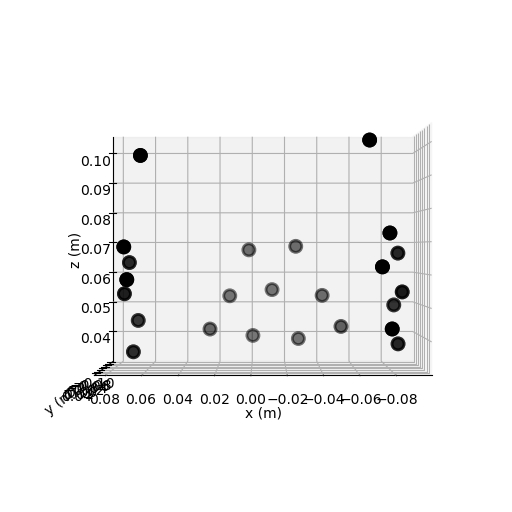

In [ ]:
importlib.reload(fnirs_3D_e)
%matplotlib qt

mod_opt_pos_1, mod_labels_1 = fnirs_3D_e.ImportPPLocations(base_folder + r"\data\3DSCAN\S" + str(1) + r"\1\1_picked_points.pp")

# keep optodes where 30mm inter-optode distance is fixed with a spacer
chs_30mm = ['S1_D1', 'S1_D2', 'S3_D4', 'S3_D6', 'S4_D4', 'S4_D6', 'S5_D7',
            'S6_D7', 'S6_D10', 'S7_D7', 'S7_D10', 'S7_D9', 'S8_D10', 'S8_D9', 'S9_D9',
            'S10_D12', 'S10_D13', 'S11_D12', 'S11_D13', 'S13_D15', 'S13_D16', 'S14_D2',  
            'S15_D16', 'S16_D2']
optodes_30mm = []
for c_ch_name in chs_30mm:
    optodes_30mm.append(c_ch_name.split('_')[0])
    optodes_30mm.append(c_ch_name.split('_')[1])
all_points = ['lpa', 'rpa', 'nas'] + list(np.unique(optodes_30mm))
mod_opt_pos_1 = mod_opt_pos_1[np.isin(mod_labels_1, all_points)]
mod_labels_1 = mod_labels_1[np.isin(mod_labels_1, all_points)]

# rigid registration
mod_opt_pos_1_cc = fnirs_3D_e.CoordinatesPipeline(mod_opt_pos_1, mod_labels_1)

# check mislabels after registration
_ = fnirs_3D_e.CheckMislabel(mod_opt_pos_1_cc, mod_labels_1, chs_30mm, tolerance=7)

# import template .nirs file
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir, verbose=True).load_data()

# adjust for 2 wavelenghts and remove excess channels
chs_30mm2 = []
[chs_30mm2.append(v) for v in chs_30mm for _ in np.arange(2)]
raw_intensity = raw_intensity.drop_channels(raw_intensity.ch_names[len(chs_30mm2):]) 
rename_ch_names = {raw_intensity.ch_names[i]: (chs_30mm2[i] + ' ' + raw_intensity.ch_names[i].split(' ')[1]) for i in range(len(raw_intensity.ch_names))}
raw_intensity = raw_intensity.rename_channels(rename_ch_names)

# add new montage and plot
montage_gen = mne.channels.make_dig_montage(ch_pos=dict(zip(mod_labels_1[~np.isin(mod_labels_1, ['lpa', 'rpa', 'nas'])], 
                                                            mod_opt_pos_1_cc[~np.isin(mod_labels_1, ['lpa', 'rpa', 'nas'])])),
                                            nasion= np.squeeze(mod_opt_pos_1_cc[mod_labels_1 == 'nas']), 
                                            lpa=    np.squeeze(mod_opt_pos_1_cc[mod_labels_1 == 'lpa']), 
                                            rpa=    np.squeeze(mod_opt_pos_1_cc[mod_labels_1 == 'rpa']),
                                            coord_frame='mni_tal')
raw_intensity.set_montage(montage_gen)
raw_intensity.plot_sensors(kind='3d')